In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error      
from torch.utils.data import DataLoader, TensorDataset
from datetime import timedelta


In [113]:
# Load and preprocess data test
data = pd.read_csv('Data/Taipei/h23-g1.csv', sep=';', parse_dates=['date_time'])
data.set_index('date_time', inplace=True)
location='Taipei'

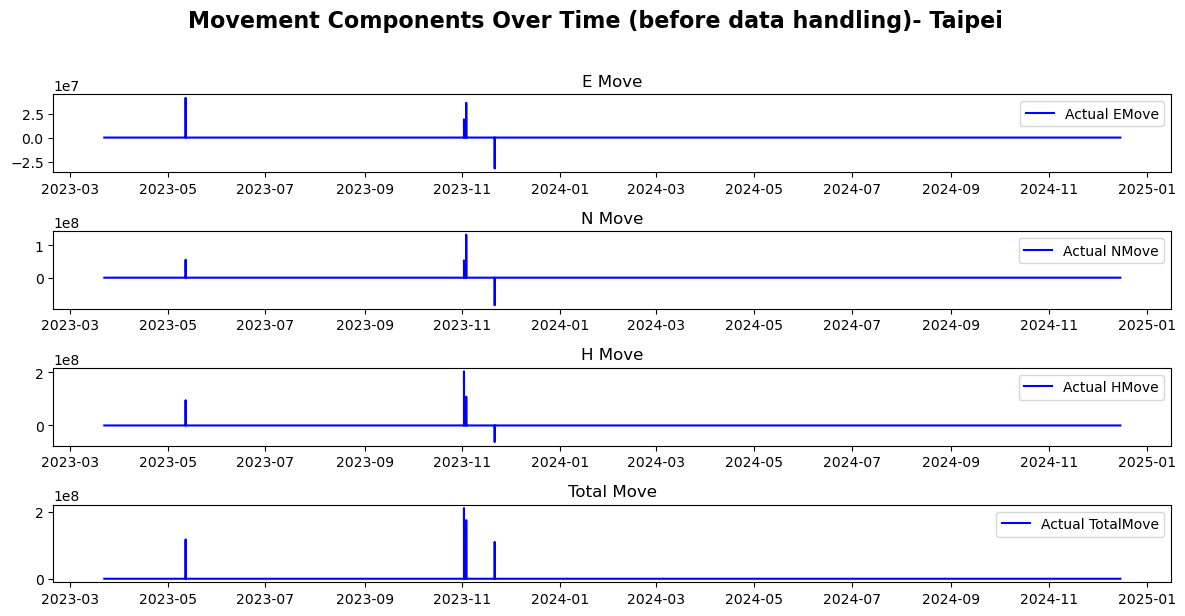

In [114]:
# Plot predictions vs actual values for  each movement component
plt.figure(figsize=(12, 6))
# Add a main title for all subplots
plt.suptitle("Movement Components Over Time (before data handling)- {}".format(location), fontsize=16, fontweight='bold', y=1.02)

plt.subplot(4, 1, 1)
plt.plot(data.index, data['EMove'], label="Actual EMove", color='blue')
#plt.plot(data.index[:len(scaled_target_data)], scaled_target_data[:, 0], label="scaled EMove", color='red', linestyle='dashed')
plt.title("E Move")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data.index, data['NMove'], label="Actual NMove", color='blue')
#plt.plot(data.index[:len(scaled_target_data)], scaled_target_data[:, 1], label="scaled EMove", color='red', linestyle='dashed')
plt.title("N Move")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data.index, data['HMove'], label="Actual HMove", color='blue')
#plt.plot(data.index[:len(scaled_target_data)], scaled_target_data[:, 2], label="scaled EMove", color='red', linestyle='dashed')
plt.title("H Move")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(data.index, data['TotalMove'], label="Actual TotalMove", color='blue')
#plt.plot(data.index[:len(scaled_target_data)], scaled_target_data[:, 3], label="scaled EMove", color='red', linestyle='dashed')
plt.title("Total Move")
plt.legend()

plt.tight_layout()
plt.show()

In [115]:
# Skip first day
data = data[data.index >= "2023-03-23  00:00:00"]
#data = data[data.index >= "2024-01-22  00:00:00"] #for 高雄
# Add hour and minute features
data['hour'] = data.index.hour
data['minute'] = data.index.minute

# Choose relevant columns
target_columns = ['EMove', 'NMove', 'HMove']
features_columns = ['hour', 'minute']

values = data[target_columns + features_columns].values  # Keep hour and minute as well

# Remove values outside 3 standard deviations
for col in target_columns:
    mean = data[col].mean()
    std = data[col].std()
    data = data[(data[col] >= mean - 3*std) & (data[col] <= mean + 3*std)]


#Normalize only the target columns (EMove, NMove, HMove) between 0 to 1   #feature_range=(-1,1)
scaler = MinMaxScaler()
scaled_target_data = scaler.fit_transform(data[target_columns])

# Combine scaled target data with original non-target features
scaled_data = np.hstack([scaled_target_data, data[features_columns].values])

# Create sequences
def create_sequences(data, seq_length=144):  #144= one day
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length][:3])  # Predict EMove, HMove, NMove
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

seq_length = 144  # 24-hour sequence for 10-min interval data
X, y = create_sequences(scaled_data, seq_length)

# Time-based split (80% train, 10% validation, 10% test) 
train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [116]:
# Define GRU model
class MovementGRU(nn.Module):
    def __init__(self, input_size=5, hidden_size=20, num_layers=2, output_size=3, dropout_rate=0.2): ### hidden size might need to be smaller, and lyers need to be middle
        super(MovementGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.dropout(gru_out)
        return self.fc(gru_out[:, -1, :])  # Predict next 10-min step

model = MovementGRU()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # learning rate (uses Adam optimizer) (dont need weight decay)

# Get the last sequence from the dataset (latest available data)
last_sequence = X[-1].unsqueeze(0)  # Shape: (1, seq_length, input_size)
last_timestamp = data.index[-seq_length:].tolist()  # Get the last seq_length timestamps

future_steps = 10  # Predict next 10 time steps (10 min per step)
predicted_timestamps = []
predicted_values = []

best_val_loss = float('inf')  # Track the best validation loss
best_model_state = None        # Save best model parameters
rollback_patience = 2  # Allow 2 epochs of worse validation loss before rollback
rollback_counter = 0 # Track consecutive bad epochs
rollback_limit = 3  # Stop if rollback happens 3 times
rollback_attempt_counter = 0  # Track consecutive rollback attempts

# Training loop
epochs = 15 
for epoch in range(epochs):
    train_loss = 0
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()  # Clears the previous gradients from the optimizer
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    # Move model to evaluation mode
    model.eval()
    y_preds = []
    y_trues = []

    with torch.no_grad():  # No need for gradient

        for batch_x, batch_y in val_loader: # Batch_y contains the true values from your validation dataset. output is what your model predicts for batch_x.
            output = model(batch_x)
            y_preds.append(output.numpy())  # Convert tensor to numpy
            y_trues.append(batch_y.numpy()) 
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    # Convert list of arrays to single NumPy array
    y_preds = np.vstack(y_preds)
    y_trues = np.vstack(y_trues)

    # Compute metrics for each feature (E_move, N_move, H_move)
    mae_E = mean_absolute_error(y_trues[:, 0], y_preds[:, 0])
    rmse_E = np.sqrt(mean_squared_error(y_trues[:, 0], y_preds[:, 0]))

    mae_N = mean_absolute_error(y_trues[:, 1], y_preds[:, 1])
    rmse_N = np.sqrt(mean_squared_error(y_trues[:, 1], y_preds[:, 1]))

    mae_H = mean_absolute_error(y_trues[:, 2], y_preds[:, 2])
    rmse_H = np.sqrt(mean_squared_error(y_trues[:, 2], y_preds[:, 2]))

    # Compute total_move (after reversing normalization)
    total_move_true = np.sqrt(y_trues[:, 0]**2 + y_trues[:, 1]**2 + y_trues[:, 2]**2)
    total_move_pred = np.sqrt(y_preds[:, 0]**2 + y_preds[:, 1]**2 + y_preds[:, 2]**2)

    # Compute MAE and RMSE for total_move
    mae_total_move = mean_absolute_error(total_move_true, total_move_pred)
    rmse_total_move = np.sqrt(mean_squared_error(total_move_true, total_move_pred))

    val_loss /= len(val_loader)
    train_loss /= len(train_loader)

    print(f"Epoch {epoch+1}:")
    print(f"Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.6f}")
    print(f"MAE - E_move: {mae_E:.5f}, N_move: {mae_N:.5f}, H_move: {mae_H:.5f}, Total Move: {mae_total_move:.5f}")
    print(f"RMSE - E_move: {rmse_E:.5f}, N_move: {rmse_N:.5f}, H_move: {rmse_H:.5f}, Total Move: {rmse_total_move:.5f} \n")

     # Fine-tuning: Save best model and roll back if needed
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        rollback_counter = 0  # Reset counter if validation improves
        rollback_attempt_counter = 0  # Reset rollback attempt counter
    else:
        rollback_counter += 1
        
        # Early stopping condition
        if rollback_attempt_counter > rollback_limit:
            print(f"Early stopping triggered after {rollback_attempt_counter + 1} rollback!")
            model.load_state_dict(best_model_state)  # Revert to best model
            break
        
        # Roll back condition
        if rollback_counter >= rollback_patience:
            rollback_attempt_counter += 1
            print(f"Rolling back to best model after {rollback_patience} bad epochs. Rolling back & reducing learning rate...")
            model.load_state_dict(best_model_state)  # Revert to best model
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5  # Reduce learning rate by half
            rollback_counter = 0  # Reset counter if validation improves


# Final evaluation on the test set
model.eval()
test_loss = 0
y_test_preds = []
y_test_trues = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x)
        y_test_preds.append(output.numpy())
        y_test_trues.append(batch_y.numpy())

# Convert to NumPy arrays
y_test_preds = np.vstack(y_test_preds)
y_test_trues = np.vstack(y_test_trues)

# Compute metrics on the test set
mae_test_E = mean_absolute_error(y_test_trues[:, 0], y_test_preds[:, 0])
rmse_test_E = np.sqrt(mean_squared_error(y_test_trues[:, 0], y_test_preds[:, 0]))

mae_test_N = mean_absolute_error(y_test_trues[:, 1], y_test_preds[:, 1])
rmse_test_N = np.sqrt(mean_squared_error(y_test_trues[:, 1], y_test_preds[:, 1]))

mae_test_H = mean_absolute_error(y_test_trues[:, 2], y_test_preds[:, 2])
rmse_test_H = np.sqrt(mean_squared_error(y_test_trues[:, 2], y_test_preds[:, 2]))

total_move_test_true = np.sqrt(y_test_trues[:, 0]**2 + y_test_trues[:, 1]**2 + y_test_trues[:, 2]**2)
total_move_test_pred = np.sqrt(y_test_preds[:, 0]**2 + y_test_preds[:, 1]**2 + y_test_preds[:, 2]**2)

mae_test_total_move = mean_absolute_error(total_move_test_true, total_move_test_pred)
rmse_test_total_move = np.sqrt(mean_squared_error(total_move_test_true, total_move_test_pred))

print("Final Test Set Evaluation:")
print(f"Final Test Loss: {test_loss/len(test_loader):.6f}")
print(f"MAE - E_move: {mae_test_E:.5f}, N_move: {mae_test_N:.5f}, H_move: {mae_test_H:.5f}, Total Move: {mae_test_total_move:.5f}")
print(f"RMSE - E_move: {rmse_test_E:.5f}, N_move: {rmse_test_N:.5f}, H_move: {rmse_test_H:.5f}, Total Move: {rmse_test_total_move:.5f}")


Epoch 1:
Train Loss: 0.01443, Val Loss: 0.005113
MAE - E_move: 0.02737, N_move: 0.04727, H_move: 0.06535, Total Move: 0.05379
RMSE - E_move: 0.03461, N_move: 0.07515, H_move: 0.09240, Total Move: 0.07639 

Epoch 2:
Train Loss: 0.00737, Val Loss: 0.005333
MAE - E_move: 0.01970, N_move: 0.05240, H_move: 0.06564, Total Move: 0.05852
RMSE - E_move: 0.02724, N_move: 0.08164, H_move: 0.09296, Total Move: 0.08462 

Epoch 3:
Train Loss: 0.00633, Val Loss: 0.005279
MAE - E_move: 0.01957, N_move: 0.05377, H_move: 0.06416, Total Move: 0.05882
RMSE - E_move: 0.02714, N_move: 0.08300, H_move: 0.09090, Total Move: 0.08439 

Rolling back to best model after 2 bad epochs. Rolling back & reducing learning rate...
Epoch 4:
Train Loss: 0.00592, Val Loss: 0.004548
MAE - E_move: 0.01956, N_move: 0.05296, H_move: 0.05631, Total Move: 0.05582
RMSE - E_move: 0.02718, N_move: 0.08120, H_move: 0.07972, Total Move: 0.07788 

Epoch 5:
Train Loss: 0.00420, Val Loss: 0.003040
MAE - E_move: 0.02022, N_move: 0.04706,

In [117]:
# Load the best model after training
model.load_state_dict(best_model_state)  # Use the best model for prediction
model.eval()  # Ensure the model is in evaluation mode

predicted_timestamps = []
predicted_values = []
next_time = data.index[-1]  # Start from last real timestamp
last_sequence = X[-1].unsqueeze(0)  # Start with last known sequence
with torch.no_grad():
    for _ in range(future_steps):
        next_pred = model(last_sequence).numpy().flatten().reshape(1, -1)  # Prediction on normalized scale
        next_pred_original = scaler.inverse_transform(next_pred[:, :3].reshape(1, -1)).flatten()

        next_time += timedelta(minutes=10)
        predicted_timestamps.append(next_time)
        predicted_values.append(next_pred_original.flatten())  # Store original scale

        time_features = np.array([[next_time.hour, next_time.minute]])  # Convert to (1,2) shape
        next_input = np.hstack([next_pred, time_features])  # Now both are (1, X)
        next_input = torch.tensor(next_input, dtype=torch.float32).unsqueeze(0)

        last_sequence = torch.cat([last_sequence[:, 1:, :], next_input], dim=1)  # Uses previous predictions as input

predicted_values = np.array(predicted_values) # Convert to NumPy array if it's a list
total_move_future = np.sqrt(predicted_values[:, 0]**2 + predicted_values[:, 1]**2 + predicted_values[:, 2]**2)

# Convert predictions into a DataFrame
predictions_df = pd.DataFrame(predicted_values, columns=['E_move', 'N_move', 'H_move'])
predictions_df['Total_Move'] = total_move_future  
predictions_df['date_time'] = predicted_timestamps

# Print or save predictions
print("\n Future predictions:")
print(predictions_df)




 Future predictions:
      E_move     N_move     H_move  Total_Move           date_time
0 -30.411570  58.219551  11.107018   66.616409 2024-12-15 11:30:00
1 -29.939817  55.873451   8.436654   63.948513 2024-12-15 11:40:00
2 -29.292542  53.312550   5.813858   61.107136 2024-12-15 11:50:00
3 -28.814619  51.596249   3.241406   59.185822 2024-12-15 12:00:00
4 -28.453592  48.071667   1.637893   55.885372 2024-12-15 12:10:00
5 -28.530149  45.211414  -0.320240   53.461613 2024-12-15 12:20:00
6 -28.283493  44.223007  -2.915717   52.575012 2024-12-15 12:30:00
7 -27.847176  43.318130  -5.261940   51.764984 2024-12-15 12:40:00
8 -27.405014  42.560787  -6.565188   51.044662 2024-12-15 12:50:00
9 -27.114813  41.962551  -7.752184   50.558533 2024-12-15 13:00:00


In [118]:
# Check if target values are all zeros
print("Min y_train:", y_train.min().item(), "Max y_train:", y_train.max().item())

# Check if model parameters are updating
before = model.fc.weight.clone().detach()
optimizer.step()
after = model.fc.weight.clone().detach()
print("Weight update difference:", (after - before).abs().sum().item())

# Check if loss is computed correctly
print("Sample model output:", output[0].detach().numpy())
print("Sample batch_y:", batch_y[0].detach().numpy())

Min y_train: 0.0 Max y_train: 1.0
Weight update difference: 0.014803379774093628
Sample model output: [0.44941363 0.7798681  0.48796725]
Sample batch_y: [0.35809523 0.9533898  0.57212   ]


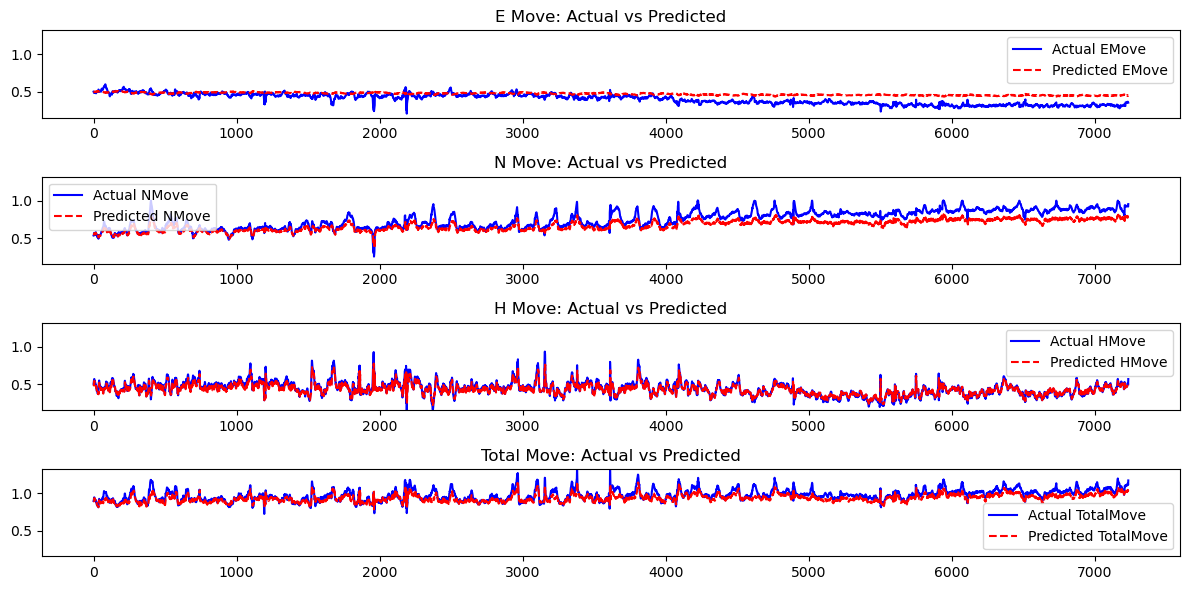

In [119]:
import matplotlib.pyplot as plt

# Find global min and max for y-axis across all movement components
y_min = min(y_test_trues.min(), y_test_preds.min(), total_move_test_true.min(), total_move_test_pred.min())
y_max = max(y_test_trues.max(), y_test_preds.max(), total_move_test_true.max(), total_move_test_pred.max())

# Plot predictions vs actual values for  each movement component
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(y_test_trues[:, 0], label="Actual EMove", color='blue')
plt.plot(y_test_preds[:, 0], label="Predicted EMove", color='red', linestyle='dashed')
plt.title("E Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(y_test_trues[:, 1], label="Actual NMove", color='blue')
plt.plot(y_test_preds[:, 1], label="Predicted NMove", color='red', linestyle='dashed')
plt.title("N Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(y_test_trues[:, 2], label="Actual HMove", color='blue')
plt.plot(y_test_preds[:, 2], label="Predicted HMove", color='red', linestyle='dashed')
plt.title("H Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(total_move_test_true, label="Actual TotalMove", color='blue')
plt.plot(total_move_test_pred, label="Predicted TotalMove", color='red', linestyle='dashed')
plt.title("Total Move: Actual vs Predicted")
plt.ylim(y_min, y_max)  # Set same y-axis range
plt.legend()

plt.tight_layout()
plt.show()

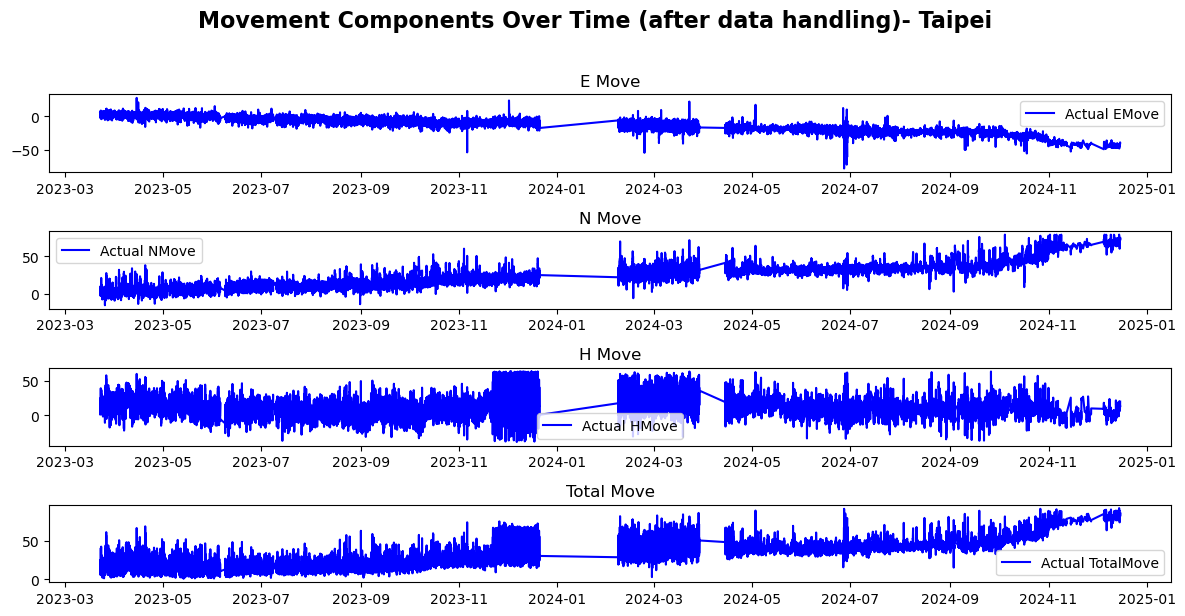

In [120]:
# Plot predictions vs actual values for  each movement component
plt.figure(figsize=(12, 6))

# Add a main title for all subplots
plt.suptitle("Movement Components Over Time (after data handling)- {}".format(location), fontsize=16, fontweight='bold', y=1.02)

plt.subplot(4, 1, 1)

plt.plot(data.index, data['EMove'], label="Actual EMove", color='blue')
#plt.plot(data.index[:len(scaled_target_data)], scaled_target_data[:, 0], label="scaled EMove", color='red', linestyle='dashed')
plt.title("E Move")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(data.index, data['NMove'], label="Actual NMove", color='blue')
#plt.plot(data.index[:len(scaled_target_data)], scaled_target_data[:, 1], label="scaled EMove", color='red', linestyle='dashed')
plt.title("N Move")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(data.index, data['HMove'], label="Actual HMove", color='blue')
#plt.plot(data.index[:len(scaled_target_data)], scaled_target_data[:, 2], label="scaled EMove", color='red', linestyle='dashed')
plt.title("H Move")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(data.index, data['TotalMove'], label="Actual TotalMove", color='blue')
#plt.plot(data.index[:len(scaled_target_data)], scaled_target_data[:, 3], label="scaled EMove", color='red', linestyle='dashed')
plt.title("Total Move")
plt.legend()

plt.tight_layout()
plt.show()